# Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statistics
import missingno as msno
%matplotlib inline

In [2]:
"""Response variable encoding -- 0 for not affected, 1 for affected (died of disease in under 10yrs), or ignore"""
def Y_encoding(data):
    Y = []
    for i in range(len(data)):
        if data['OS_MONTHS'][i] > 120:
            Y.append(0) # not affected
        elif data['VITAL_STATUS'][i] == "Died of Disease":
            Y.append(1) # affected
        else:
            Y.append(-1) # ignore
    return Y

### EDA: Clinical Patient Data

In [3]:
clinical = pd.read_csv("../data/data_clinical_patient.txt", sep='\t', skiprows=4,index_col=0)
print("Pulled clinical data on %d patients" % len(clinical))

Pulled clinical data on 2509 patients


Now, we plot the matrix of missing values. We see the bottom of the matrix is very sparse. But this will get cleared up shortly.

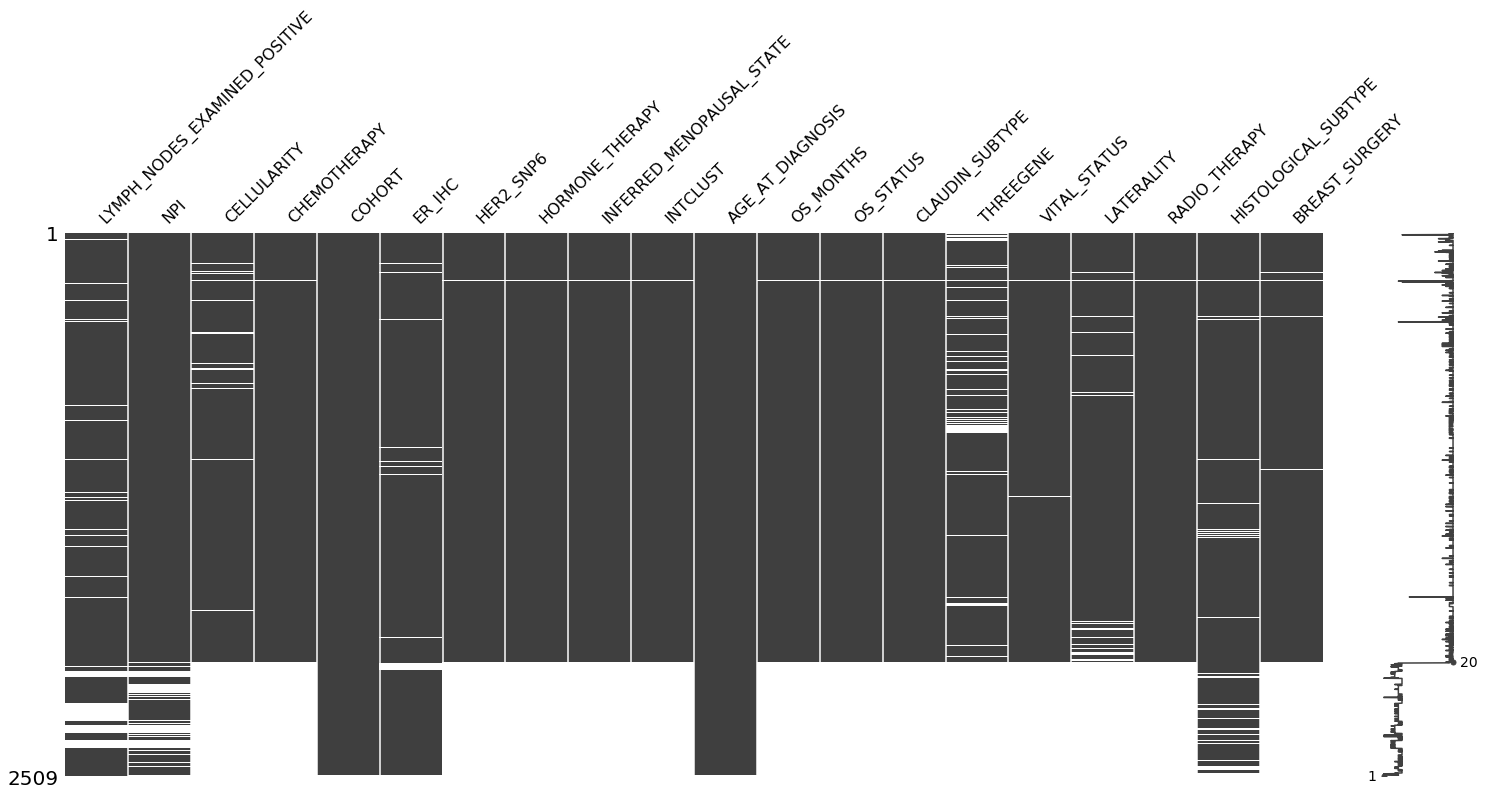

In [4]:
"""Plot the matrix of missing values"""
missing_cols = clinical.columns[clinical.isnull().any()].tolist()
msno.matrix(clinical[missing_cols])

In [5]:
clinical['Y'] = Y_encoding(clinical)
clinical = clinical[clinical['Y'] != -1]
print("%d patients remaining after removing ignore class" % len(clinical))

1469 patients remaining after removing ignore class


After removing the ignore class, we are left with few missing values

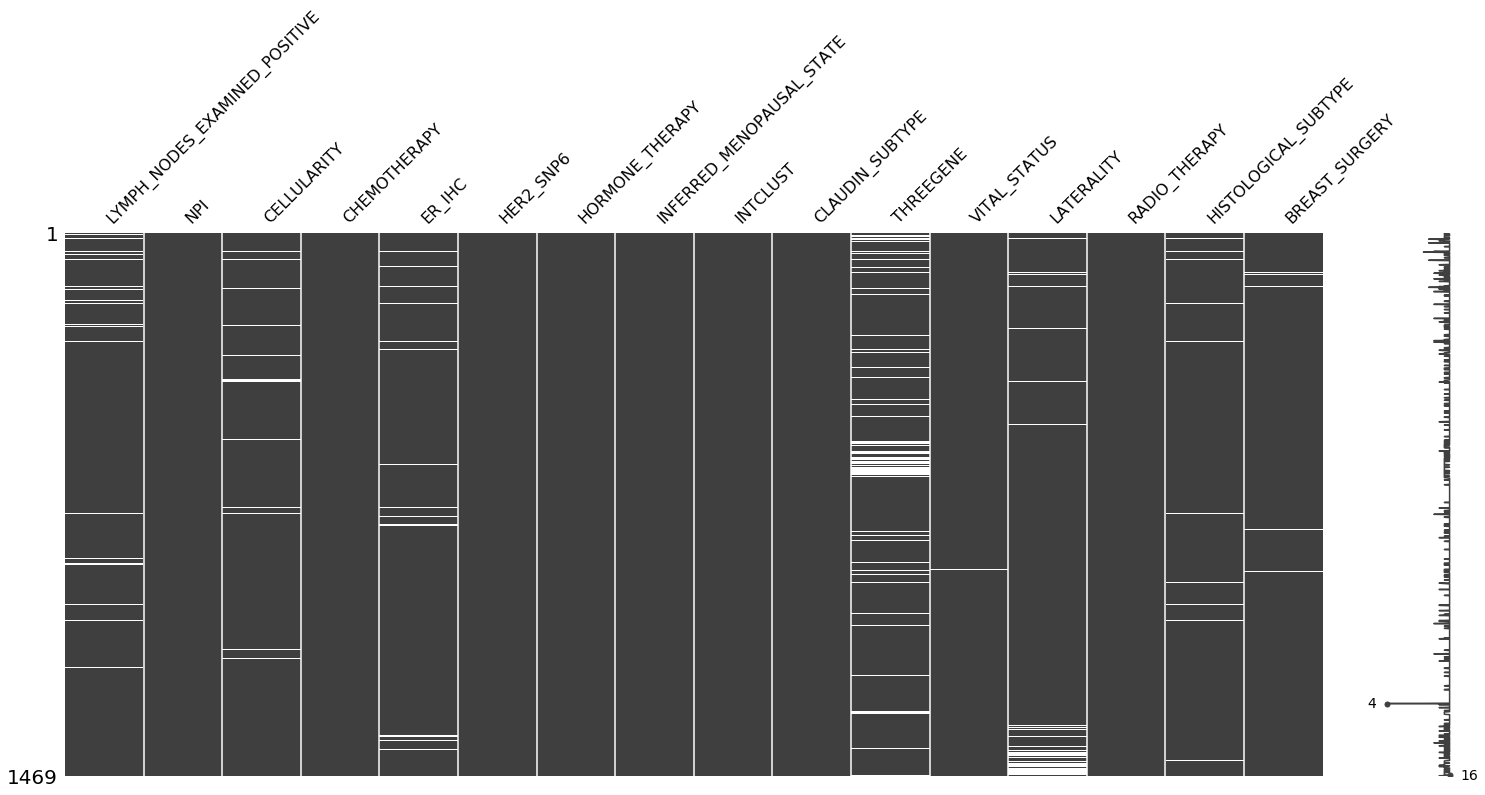

In [6]:
"""Plot the matrix of missing values"""
missing_cols = clinical.columns[clinical.isnull().any()].tolist()
msno.matrix(clinical[missing_cols])

We can plot missing value correlations

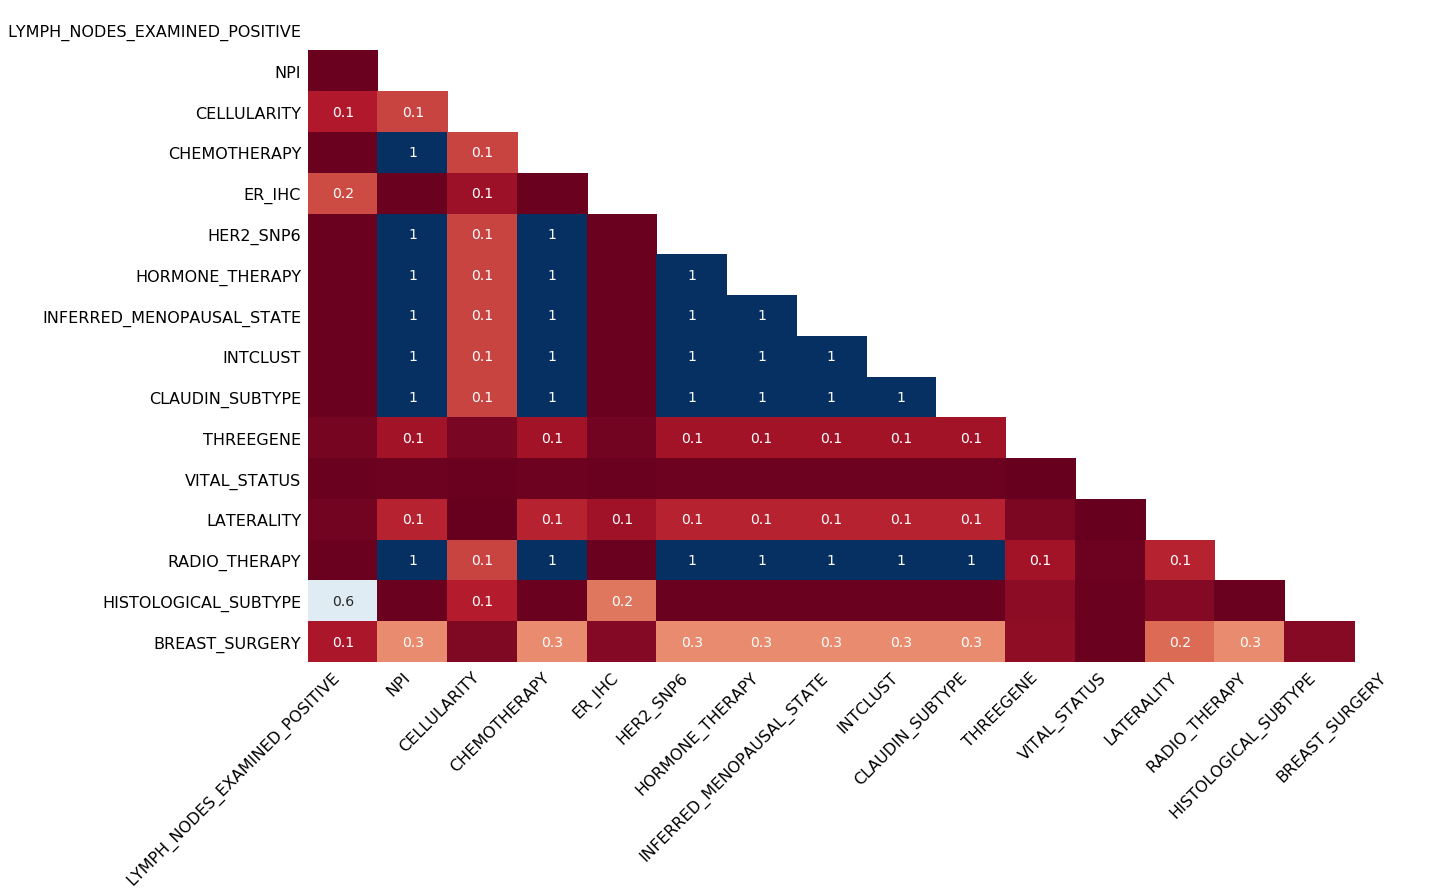

In [7]:
msno.heatmap(clinical[missing_cols])

But the ones in this plot are misleading since NPI, CHEMOTHERAPY, HER2_SNP6, HORMONE_THERAPY, INFERRED_MENOPAUSAL_STATE, INTCLUST, and CLAUDIN_SUBTYPE all have only 1 missing value.

In [8]:
null = clinical.isnull().sum(axis=0)
print("%d null values" % sum(null))
print()
print(null)

437 null values

LYMPH_NODES_EXAMINED_POSITIVE     59
NPI                                1
CELLULARITY                       41
CHEMOTHERAPY                       1
COHORT                             0
ER_IHC                            30
HER2_SNP6                          1
HORMONE_THERAPY                    1
INFERRED_MENOPAUSAL_STATE          1
INTCLUST                           1
AGE_AT_DIAGNOSIS                   0
OS_MONTHS                          0
OS_STATUS                          0
CLAUDIN_SUBTYPE                    1
THREEGENE                        171
VITAL_STATUS                       1
LATERALITY                        84
RADIO_THERAPY                      1
HISTOLOGICAL_SUBTYPE              28
BREAST_SURGERY                    15
Y                                  0
dtype: int64


We remove these isolated missing values and try again

In [9]:
for col in clinical.columns:
    if col in list(null.index):
        if null[col] == 1:
            clinical = clinical[pd.notnull(clinical[col])]

In [10]:
null = clinical.isnull().sum(axis=0)
print("%d null values" % sum(null))
print()
print(null)

424 null values

LYMPH_NODES_EXAMINED_POSITIVE     59
NPI                                0
CELLULARITY                       40
CHEMOTHERAPY                       0
COHORT                             0
ER_IHC                            30
HER2_SNP6                          0
HORMONE_THERAPY                    0
INFERRED_MENOPAUSAL_STATE          0
INTCLUST                           0
AGE_AT_DIAGNOSIS                   0
OS_MONTHS                          0
OS_STATUS                          0
CLAUDIN_SUBTYPE                    0
THREEGENE                        170
VITAL_STATUS                       0
LATERALITY                        83
RADIO_THERAPY                      0
HISTOLOGICAL_SUBTYPE              28
BREAST_SURGERY                    14
Y                                  0
dtype: int64


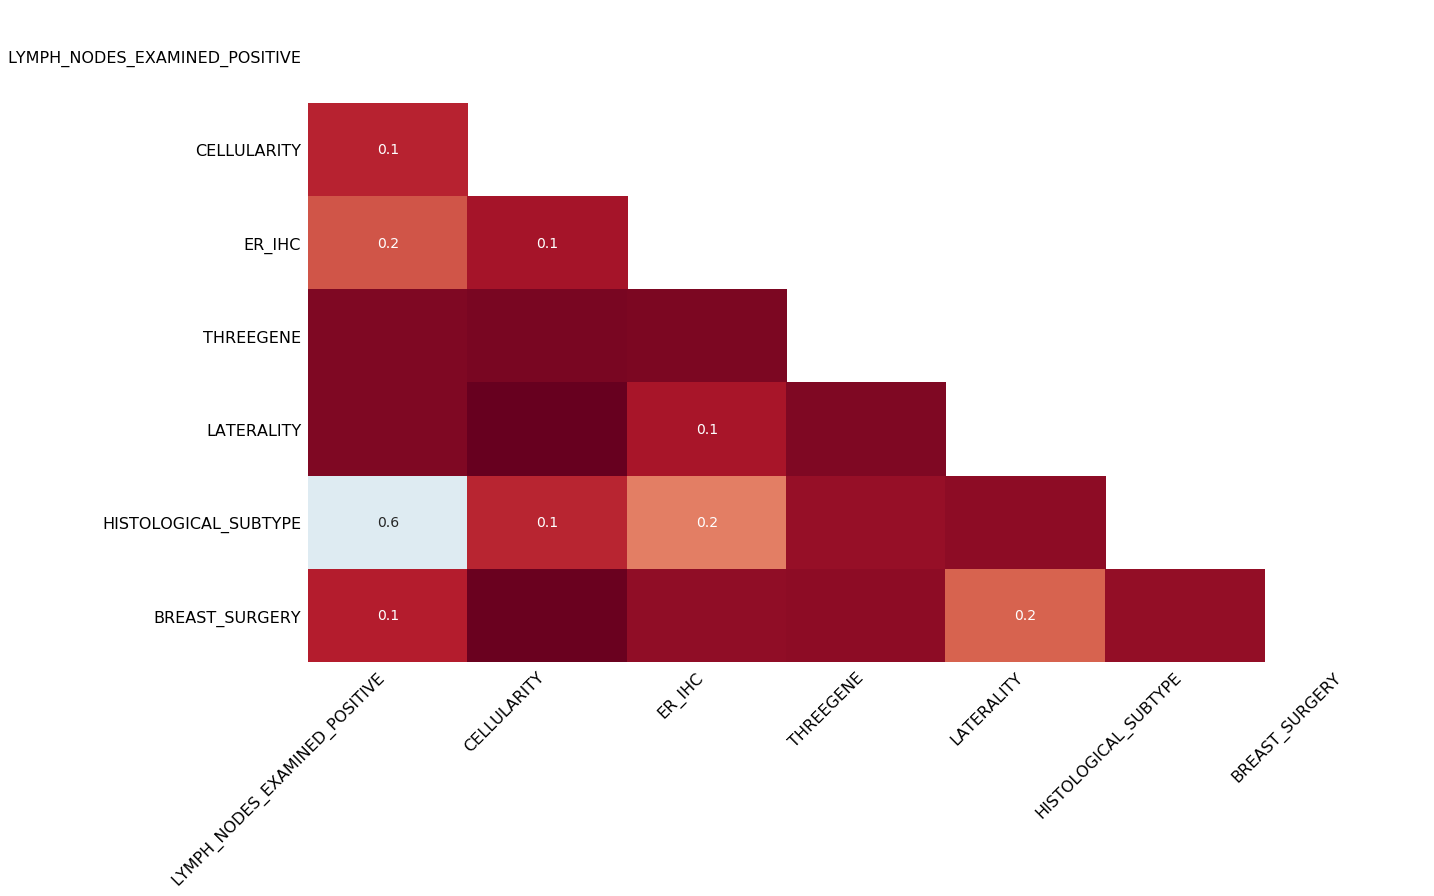

In [11]:
missing_cols = clinical.columns[clinical.isnull().any()].tolist()
msno.heatmap(clinical[missing_cols])

We might consider imputation for our single continuous quantitative variable with missing values: the Lymph Node count. To consider our options, we plot the distribution of lymph node counts

[]

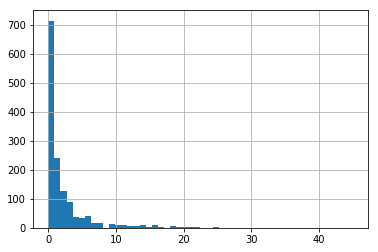

In [12]:
lymph_node_counts = clinical[clinical["LYMPH_NODES_EXAMINED_POSITIVE"].notnull()]
lymph_node_counts = lymph_node_counts["LYMPH_NODES_EXAMINED_POSITIVE"]
hist = lymph_node_counts.hist(bins=50)
hist.plot()

This distribution is far from uniform. For this reason, we will not impute values with the mean lymph node count as this could severely bias the data. We take another look at whether lymph node counts are clearly not missing at random. To do so, we use boxplots. But as we saw before, we won't get a good reading on the association between missing lymph node count and histological subtype since their nullity is highly correlated. We look now at the table. When lymph node counts are missing, we find that NPI is not missing. Since NPI is continuous, we can get a good sense for the associations

In [13]:
clinical[clinical['LYMPH_NODES_EXAMINED_POSITIVE'].isnull()].isnull().sum(axis=0)

LYMPH_NODES_EXAMINED_POSITIVE    59
NPI                               0
CELLULARITY                       6
CHEMOTHERAPY                      0
COHORT                            0
ER_IHC                            8
HER2_SNP6                         0
HORMONE_THERAPY                   0
INFERRED_MENOPAUSAL_STATE         0
INTCLUST                          0
AGE_AT_DIAGNOSIS                  0
OS_MONTHS                         0
OS_STATUS                         0
CLAUDIN_SUBTYPE                   0
THREEGENE                         8
VITAL_STATUS                      0
LATERALITY                        4
RADIO_THERAPY                     0
HISTOLOGICAL_SUBTYPE             23
BREAST_SURGERY                    3
Y                                 0
dtype: int64

In [14]:
clinical["NULL_NODES"] = clinical['LYMPH_NODES_EXAMINED_POSITIVE'].isnull()
x = list(clinical['NPI'])
y = list(clinical['NULL_NODES'])
Falses = []
Trues = []
for i in range(len(x)):
    if not np.isnan(x[i]):
        if y[i]:
            Trues.append(x[i])
        else:
            Falses.append(x[i])

In [15]:
print("We have %d Trues and %d Falses" % (len(Trues), len(Falses)))

We have 59 Trues and 1408 Falses


{'boxes': [<matplotlib.lines.Line2D at 0x1a1ee73d68>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1eeb3da0>,
 'fliers': [<matplotlib.lines.Line2D at 0x10bc9efd0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x10bc9e7b8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1a1ee66668>,
  <matplotlib.lines.Line2D at 0x10bcafeb8>]}

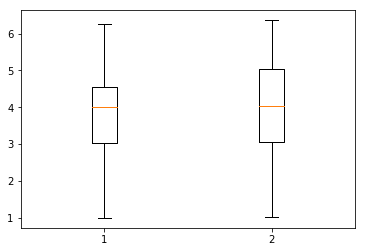

In [16]:
plt.boxplot([Trues, Falses])

It appears that the nullity of the lymph node count would not be able to predict NPI. Let's try age at diagnosis.

{'boxes': [<matplotlib.lines.Line2D at 0x1a1f14bf60>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1f154e10>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a1f166d30>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a1f15ee80>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1a1f1546d8>,
  <matplotlib.lines.Line2D at 0x1a1f16ff28>]}

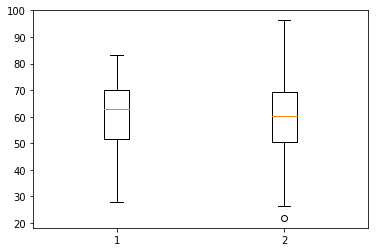

In [20]:
x = list(clinical['AGE_AT_DIAGNOSIS'])
y = list(clinical['NULL_NODES'])
Falses = []
Trues = []
for i in range(len(x)):
    if not np.isnan(x[i]):
        if y[i]:
            Trues.append(x[i])
        else:
            Falses.append(x[i])
plt.boxplot([Trues, Falses])

Again, the nullity of lymph node count does not seem to predict the age at diagnosis. Let's next consider the nullity of histological subtype with NPI

We have 28 Trues and 1439 Falses


{'boxes': [<matplotlib.lines.Line2D at 0x1a1f3c0668>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1f3c8ba8>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a1f3cfdd8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a1f3cf5c0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1a1f3c0da0>,
  <matplotlib.lines.Line2D at 0x1a1f3e0cc0>]}

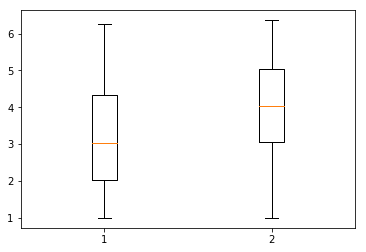

In [22]:
clinical["NULL_HIST"] = clinical['HISTOLOGICAL_SUBTYPE'].isnull()
x = list(clinical['NPI'])
y = list(clinical['NULL_HIST'])
Falses = []
Trues = []
for i in range(len(x)):
    if not np.isnan(x[i]):
        if y[i]:
            Trues.append(x[i])
        else:
            Falses.append(x[i])

print("We have %d Trues and %d Falses" % (len(Trues), len(Falses)))
plt.boxplot([Trues, Falses])

and with age

We have 28 Trues and 1439 Falses


{'boxes': [<matplotlib.lines.Line2D at 0x1a1f28c6d8>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1f294c88>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a1f29ceb8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a1f29c6a0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1a1f28ce10>,
  <matplotlib.lines.Line2D at 0x1a1f2acda0>]}

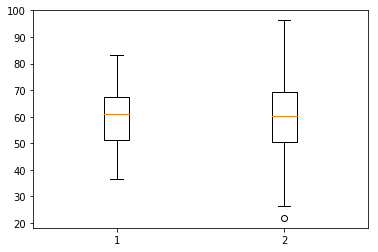

In [21]:
clinical["NULL_HIST"] = clinical['HISTOLOGICAL_SUBTYPE'].isnull()
x = list(clinical['AGE_AT_DIAGNOSIS'])
y = list(clinical['NULL_HIST'])
Falses = []
Trues = []
for i in range(len(x)):
    if not np.isnan(x[i]):
        if y[i]:
            Trues.append(x[i])
        else:
            Falses.append(x[i])

print("We have %d Trues and %d Falses" % (len(Trues), len(Falses)))
plt.boxplot([Trues, Falses])

Although it is impossible to prove MCAR with certainty, we assume this is the case for the missing lymph node counts and histological subtype. We simply remove them listwise. We also drop our added null columns.

In [28]:
clinical = clinical[pd.notnull(clinical['LYMPH_NODES_EXAMINED_POSITIVE'])]
clinical = clinical[pd.notnull(clinical['HISTOLOGICAL_SUBTYPE'])]
clinical.drop('NULL_HIST', axis=1, inplace=True)
clinical.drop('NULL_NODES', axis=1, inplace=True)

In [30]:
null = clinical.isnull().sum(axis=0)
print("%d null values" % sum(null))
print()
print(null)

306 null values

LYMPH_NODES_EXAMINED_POSITIVE      0
NPI                                0
CELLULARITY                       34
CHEMOTHERAPY                       0
COHORT                             0
ER_IHC                            22
HER2_SNP6                          0
HORMONE_THERAPY                    0
INFERRED_MENOPAUSAL_STATE          0
INTCLUST                           0
AGE_AT_DIAGNOSIS                   0
OS_MONTHS                          0
OS_STATUS                          0
CLAUDIN_SUBTYPE                    0
THREEGENE                        161
VITAL_STATUS                       0
LATERALITY                        78
RADIO_THERAPY                      0
HISTOLOGICAL_SUBTYPE               0
BREAST_SURGERY                    11
Y                                  0
dtype: int64


For the remaining 5 categorical variables containing null values, we can incorporate into our one-hot-encodings new dummy variables to represent whether or not the variable was null.

### Scratch

In [77]:
clinical.corr()

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,COHORT,AGE_AT_DIAGNOSIS,OS_MONTHS,Y,NULL_HIST,NULL_ER,NULL_NODES,NULL_LATERALITY
LYMPH_NODES_EXAMINED_POSITIVE,1.000000,0.567362,-0.036175,0.007154,-0.314137,0.302615,0.001667,-0.061147,NaN,0.085822
NPI,0.567362,1.000000,-0.067707,-0.089536,-0.336803,0.332001,-0.103043,-0.175810,-0.084929,0.063020
COHORT,-0.036175,-0.067707,1.000000,0.045628,0.071119,-0.035956,-0.060941,-0.027122,-0.097039,0.151198
AGE_AT_DIAGNOSIS,0.007154,-0.089536,0.045628,1.000000,-0.088428,0.043840,-0.011356,0.016796,0.008621,-0.014957
OS_MONTHS,-0.314137,-0.336803,0.071119,-0.088428,1.000000,-0.840378,0.036268,0.031772,0.004210,-0.147796
Y,0.302615,0.332001,-0.035956,0.043840,-0.840378,1.000000,-0.060847,-0.055818,-0.034254,0.104236
NULL_HIST,0.001667,-0.103043,-0.060941,-0.011356,0.036268,-0.060847,1.000000,0.226239,0.554651,0.030530
NULL_ER,-0.061147,-0.175810,-0.027122,0.016796,0.031772,-0.055818,0.226239,1.000000,0.166535,0.068849
NULL_NODES,NaN,-0.084929,-0.097039,0.008621,0.004210,-0.034254,0.554651,0.166535,1.000000,0.009940
NULL_LATERALITY,0.085822,0.063020,0.151198,-0.014957,-0.147796,0.104236,0.030530,0.068849,0.009940,1.000000


In [66]:
clinical[['LYMPH_NODES_EXAMINED_POSITIVE', 'NPI', 'CELLULARITY', 'CHEMOTHERAPY',
       'COHORT', 'ER_IHC', 'HER2_SNP6', 'HORMONE_THERAPY',
       'INFERRED_MENOPAUSAL_STATE', 'INTCLUST', 'AGE_AT_DIAGNOSIS',
       'OS_MONTHS', 'OS_STATUS', 'CLAUDIN_SUBTYPE', 'THREEGENE',
       'VITAL_STATUS', 'LATERALITY', 'RADIO_THERAPY', 'HISTOLOGICAL_SUBTYPE',
       'BREAST_SURGERY']]

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,CHEMOTHERAPY,COHORT,ER_IHC,HER2_SNP6,HORMONE_THERAPY,INFERRED_MENOPAUSAL_STATE,INTCLUST,AGE_AT_DIAGNOSIS,OS_MONTHS,OS_STATUS,CLAUDIN_SUBTYPE,THREEGENE,VITAL_STATUS,LATERALITY,RADIO_THERAPY,HISTOLOGICAL_SUBTYPE,BREAST_SURGERY
PATIENT_ID,,,,,,,,,,,,,,,,,,,,
MB-0000,10.0,6.044,NaN,NO,1.0,Positve,NEUTRAL,YES,Post,4ER+,75.65,140.500000,LIVING,claudin-low,ER-/HER2-,Living,Right,YES,Ductal/NST,MASTECTOMY
MB-0005,1.0,4.030,High,YES,1.0,Positve,NEUTRAL,YES,Pre,3,48.87,163.700000,DECEASED,LumB,None,Died of Disease,Right,NO,Ductal/NST,MASTECTOMY
MB-0006,3.0,4.050,Moderate,YES,1.0,Positve,NEUTRAL,YES,Pre,9,47.68,164.933333,LIVING,LumB,None,Living,Right,YES,Mixed,MASTECTOMY
MB-0008,8.0,6.080,High,YES,1.0,Positve,NEUTRAL,YES,Post,9,76.97,41.366667,DECEASED,LumB,ER+/HER2- High Prolif,Died of Disease,Right,YES,Mixed,MASTECTOMY
MB-0010,0.0,4.062,Moderate,NO,1.0,Positve,NEUTRAL,YES,Post,7,78.77,7.800000,DECEASED,LumB,ER+/HER2- High Prolif,Died of Disease,Left,YES,Ductal/NST,MASTECTOMY
MB-0014,1.0,4.020,Moderate,YES,1.0,Positve,LOSS,YES,Post,3,56.45,164.333333,LIVING,LumB,None,Living,Right,YES,Ductal/NST,BREAST CONSERVING
MB-0020,NaN,6.130,High,YES,1.0,Negative,NEUTRAL,NO,Post,4ER-,70.00,22.400000,DECEASED,Normal,ER-/HER2-,Died of Disease,Left,YES,Lobular,MASTECTOMY
MB-0035,0.0,3.056,High,NO,1.0,Negative,LOSS,NO,Post,3,84.22,36.266667,DECEASED,Her2,ER+/HER2- High Prolif,Died of Disease,Left,NO,Lobular,MASTECTOMY
MB-0036,0.0,3.044,Moderate,NO,1.0,Positve,NEUTRAL,YES,Post,3,85.49,132.033333,DECEASED,LumA,ER+/HER2- Low Prolif,Died of Disease,Left,YES,Ductal/NST,MASTECTOMY


In [55]:
clinical['THREEGENE'] = clinical['THREEGENE'].fillna(value="None")

In [58]:
clinical.columns

Index(['LYMPH_NODES_EXAMINED_POSITIVE', 'NPI', 'CELLULARITY', 'CHEMOTHERAPY',
       'COHORT', 'ER_IHC', 'HER2_SNP6', 'HORMONE_THERAPY',
       'INFERRED_MENOPAUSAL_STATE', 'INTCLUST', 'AGE_AT_DIAGNOSIS',
       'OS_MONTHS', 'OS_STATUS', 'CLAUDIN_SUBTYPE', 'THREEGENE',
       'VITAL_STATUS', 'LATERALITY', 'RADIO_THERAPY', 'HISTOLOGICAL_SUBTYPE',
       'BREAST_SURGERY', 'Y', 'NULL_HIST', 'NULL_ER', 'NULL_NODES',
       'NULL_LATERALITY'],
      dtype='object')

In [60]:
onehotencoder = OneHotEncoder(categorical_features=[14])
onehotencoder.fit_transform(clinical)

ValueError: could not convert string to float: 'BREAST CONSERVING'

In [61]:
clinical["THREEGENE"]

PATIENT_ID
MB-0000                ER-/HER2-
MB-0005                     None
MB-0006                     None
MB-0008    ER+/HER2- High Prolif
MB-0010    ER+/HER2- High Prolif
MB-0014                     None
MB-0020                ER-/HER2-
MB-0035    ER+/HER2- High Prolif
MB-0036     ER+/HER2- Low Prolif
MB-0039                     None
MB-0045                     None
MB-0053                     None
MB-0054                     None
MB-0059    ER+/HER2- High Prolif
MB-0060    ER+/HER2- High Prolif
MB-0062                     None
MB-0066    ER+/HER2- High Prolif
MB-0071                     None
MB-0079                     None
MB-0083                     None
MB-0093                     None
MB-0099                     None
MB-0100                ER-/HER2-
MB-0101     ER+/HER2- Low Prolif
MB-0102    ER+/HER2- High Prolif
MB-0107                     None
MB-0108                     None
MB-0110                     None
MB-0111     ER+/HER2- Low Prolif
MB-0112     ER+/HER2- Low Prolif

### EDA: Mutations Data

In [35]:
mutations = pd.read_csv("../data/data_mutations_mskcc.txt", sep='\t', skiprows=1, index_col=0)
print("Pulled mutations data on %d genes" % len(mutations))

Pulled mutations data on 17272 genes


In [36]:
patient_dict = {}

with open("../data/data_mutations_mskcc.txt", "r") as fin:
    patient_line = fin.readline()
print(patient_line)
patient_line.strip("\n")
patient_mutation = patient_line.split(" ")[2:]
for patient in patient_mutation:
    if patient not in patient_dict.keys():
        cc = len( patient_dict)
        patient_dict[patient.strip()] = len(patient_dict)
        dd = len(patient_dict)
        if cc != dd-1:
            print("dict wrong assigned")
            exit(0)

#Sequenced_Samples: MB-0492 MB-7008 MB-2770 MB-7060 MB-2771 MB-0537 MB-7083 MB-7095 MB-2790 MB-2815 MB-7025 MB-2969 MB-0531 MB-2792 MB-7048 MB-7003 MB-7088 MB-7005 MB-0528 MB-7000 MB-7044 MB-7063 MB-7055 MB-2803 MB-7049 MB-2823 MB-7082 MB-2847 MB-7093 MB-0506 MB-7061 MB-7041 MB-7040 MB-0559 MTS-T0035 MB-7099 MB-0532 MB-7052 MB-7092 MB-0544 MB-2840 MB-7058 MB-2764 MB-2838 MB-2819 MB-0522 MB-7062 MB-7002 MB-2772 MB-7010 MB-0550 MB-7097 MB-7013 MB-2846 MB-0541 MB-7059 MB-2774 MTS-T0058 MTS-T0059 MTS-T0060 MTS-T0061 MTS-T0062 MTS-T0063 MTS-T0064 MTS-T0065 MTS-T0066 MTS-T0067 MTS-T0068 MTS-T0069 MTS-T0070 MTS-T0071 MTS-T0072 MTS-T0073 MTS-T0074 MTS-T0075 MTS-T0076 MTS-T0077 MTS-T0078 MTS-T0079 MTS-T0080 MTS-T0081 MTS-T0082 MTS-T0083 MTS-T0084 MTS-T0085 MTS-T0086 MTS-T0087 MTS-T0088 MTS-T0089 MTS-T0090 MTS-T0091 MTS-T0092 MTS-T0093 MTS-T0094 MTS-T0095 MB-7032 MB-7006 MB-0469 MB-7068 MB-7004 MB-7057 MB-0538 MB-7056 MB-7094 MB-7045 MB-7031 MB-7074 MB-0552 MB-2957 MB-7087 MB-7084 MB-7037 MB-703

In [37]:
mutation_dnas = []
for dna in mutations.index:
    if dna not in mutation_dnas:
        mutation_dnas.append(dna)

In [96]:
len(set(mutations.index))

173

In [38]:
mutations["ID"] = mutations["Variant_Classification"] + mutations.index

In [48]:
labelencoder = LabelEncoder()
mutations["ID"] = labelencoder.fit_transform(mutations["ID"])

In [78]:
max_idx = len(set(mutations["ID"])) - 1
one = lst_one_hot([], max_idx)

In [72]:
def lst_one_hot(lst, size):
    onehot = np.zeros(size)
    for i in lst:
        onehot[i] = 1
    return list(onehot)

In [88]:
cumulative_array = []
all_patients = list(set(mutations["Tumor_Sample_Barcode"]))
size = len(set(mutations["ID"]))
empty_vector = list(np.zeros(size))
for patient in all_patients:
    patient_mutation_array = []
    mutation_rows = mutations[mutations["Tumor_Sample_Barcode"] == patient]
    lst = list(set(mutation_rows["ID"]))
    if len(lst)>0:
        #row = [patient, *lst_one_hot(lst, size)]
        cumulative_array.append(lst_one_hot(lst, size))

In [89]:
arr = np.array(cumulative_array)

In [90]:
arr.shape

(2369, 885)

In [91]:
def pca(X=np.array([]), no_dims=50):
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y

In [79]:
arr

array([], dtype=float64)

In [92]:
Y = pca(arr)

In [94]:
Y[0]

array([ 0.56070742+0.j, -0.30102759+0.j, -0.62408107+0.j,  0.19035753+0.j,
       -0.08412549+0.j, -0.25079474+0.j, -0.8015496 +0.j,  0.29977409+0.j,
        0.78934993+0.j,  0.24681446+0.j,  0.12983693+0.j, -0.16318156+0.j,
       -0.12259117+0.j,  0.16829632+0.j,  0.06808201+0.j, -0.20751279+0.j,
       -0.06853552+0.j, -0.00956385+0.j,  0.10478069+0.j,  0.05977634+0.j,
        0.00365504+0.j,  0.0089545 +0.j,  0.0131406 +0.j,  0.04755764+0.j,
       -0.08590702+0.j,  0.0211287 +0.j, -0.01134363+0.j, -0.03309056+0.j,
        0.09114606+0.j, -0.06731693+0.j,  0.00487582+0.j,  0.09498455+0.j,
        0.01486319+0.j,  0.08071824+0.j, -0.01387679+0.j,  0.05029671+0.j,
        0.00848826+0.j,  0.04117798+0.j, -0.07133607+0.j, -0.01323522+0.j,
        0.02221343+0.j, -0.02715143+0.j,  0.05639183+0.j,  0.06825994+0.j,
       -0.00735686+0.j, -0.00965067+0.j, -0.00436764+0.j, -0.01194689+0.j,
        0.04743023+0.j,  0.01278985+0.j])